# Bayesian Linear Regression

In [4]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate("."); Pkg.instantiate(); 

  Activating project at `~/.julia/dev/RxInfer.jl/examples`


In [30]:
using RxInfer, Random, Plots, StableRNGs, BenchmarkTools

## Univariate regression with known noise

In this example, we are going to perform a simple linear regression problem, but in the Bayesian setting. We specify the model's likelihood as:

$$\begin{aligned}
y_i = \mathcal{N}(y_i | a * x_i + b , 1.0)
\end{aligned}$$

where $x_i$ and $y_i$ are observed values and $a$ and $b$ are random variables with the following priors:

$$\begin{aligned}
    p(a) &= \mathcal{N}(a|m_a, v_a) \\
    p(b) &= \mathcal{N}(b|m_b, v_b) 
\end{aligned}$$

In [41]:
@model function linear_regression(n)
    a ~ NormalMeanVariance(0.0, 1.0)
    b ~ NormalMeanVariance(0.0, 100.0)
    
    x = datavar(Float64, n)
    y = datavar(Float64, n)
    
    for i in 1:n
        y[i] ~ NormalMeanVariance(a * x[i] + b, 1.0)
    end
end

In order to test our inference procedure we create a test dataset where observations are corrupted with noise. During the inference procedure known variance we, however, do not know the exact magnitude of the noise.

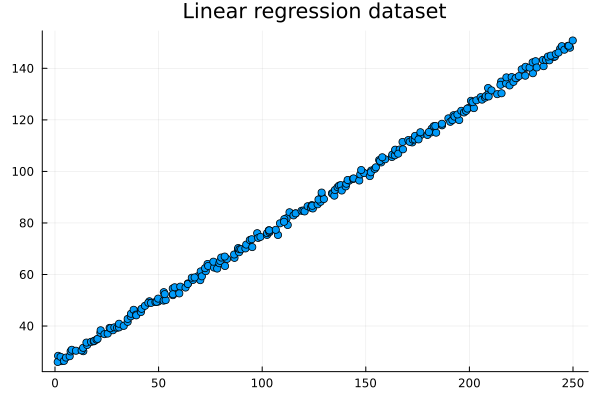

In [42]:
reala = 0.5
realb = 25.0
realv = 1.0

N = 250

rng = StableRNG(1234)

xorig = collect(1:N)

xdata = xorig .+ randn(rng, N)
ydata = rand.(NormalMeanVariance.(realb .+ reala .* xorig, realv))

scatter(xdata, ydata, title = "Linear regression dataset", legend=false)

In order to run inference with the static dataset we use the `inference` function from `RxInfer` package.

In [44]:
results = inference(
    model = linear_regression(length(xdata)), 
    data  = (y = ydata, x = xdata), 
    initmessages = (b = NormalMeanVariance(0.0, 100.0), ), 
    returnvars   = (a = KeepLast(), b = KeepLast()), 
    iterations = 20,
);

After the inference has been completed it is interesting to compare prior distribution and posterior distribution against the real values:

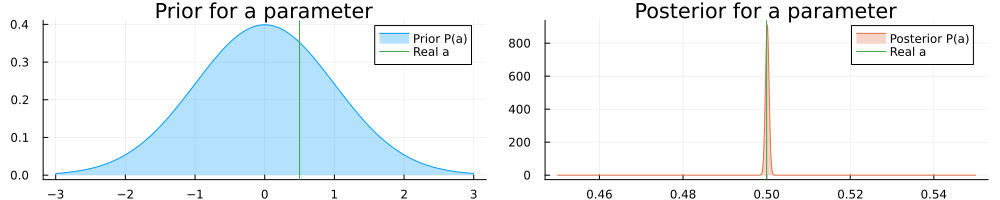

In [45]:
pra = plot(range(-3, 3, length = 1000), (x) -> pdf(NormalMeanVariance(0.0, 1.0), x), title="Prior for a parameter", fillalpha=0.3, fillrange = 0, label="Prior P(a)", c=1,)
pra = vline!(pra, [ reala ], label="Real a", c = 3)
psa = plot(range(0.45, 0.55, length = 1000), (x) -> pdf(results.posteriors[:a], x), title="Posterior for a parameter", fillalpha=0.3, fillrange = 0, label="Posterior P(a)", c=2,)
psa = vline!(psa, [ reala ], label="Real a", c = 3)

plot(pra, psa, size = (1000, 200))

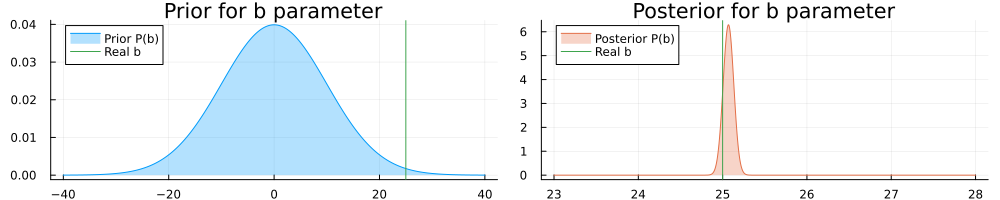

In [46]:
prb = plot(range(-40, 40, length = 1000), (x) -> pdf(NormalMeanVariance(0.0, 100.0), x), title="Prior for b parameter", fillalpha=0.3, fillrange = 0, label="Prior P(b)", c=1, legend = :topleft)
prb = vline!(prb, [ realb ], label="Real b", c = 3)
psb = plot(range(23, 28, length = 1000), (x) -> pdf(results.posteriors[:b], x), title="Posterior for b parameter", fillalpha=0.3, fillrange = 0, label="Posterior P(b)", c=2, legend = :topleft)
psb = vline!(psb, [ realb ], label="Real b", c = 3)

plot(prb, psb, size = (1000, 200))

In [47]:
a = results.posteriors[:a]
b = results.posteriors[:b]

println("Real a: ", reala, " | Estimated a: ", mean_var(a), " | Error: ", abs(mean(a) - reala))
println("Real b: ", realb, " | Estimated b: ", mean_var(b), " | Error: ", abs(mean(b) - realb))

Real a: 0.5 | Estimated a: (0.5001469323297124, 1.9152402435219974e-7) | Error: 0.00014693232971241255
Real b: 25.0 | Estimated b: (25.06921993014748, 0.004015967531215887) | Error: 0.0692199301474794


We can see that ReactiveMP.jl estimated real values of linear regression coefficients with high precision. 

## Univariate regression with unknown noise

For this demo we are going to increase the amount of noise in the dataset, but also instead of using a fixed value for the noise in the model we are going to make it a random variable with its own prior:

$$\begin{aligned}
p(s) = \mathcal{IG}(s|\alpha, \theta)
\end{aligned}$$

In [53]:
@model function linear_regression_unknown_noise(n)
    a ~ NormalMeanVariance(0.0, 1.0)
    b ~ NormalMeanVariance(0.0, 100.0)
    s ~ InverseGamma(1.0, 1.0)
    
    x = datavar(Float64, n)
    y = datavar(Float64, n)
    
    for i in 1:n
        y[i] ~ NormalMeanVariance(a * x[i] + b, s)
    end
end

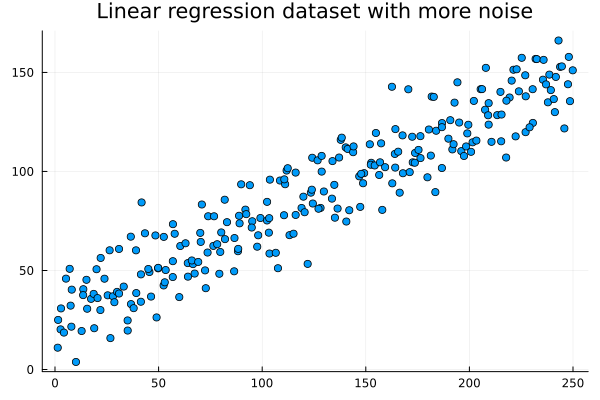

In [73]:
reala_un = 0.5
realb_un = 25.0
realv_un = 200.0

N_un = 250

rng_un = StableRNG(1234)

xorig_un = collect(1:N)

xdata_un = xorig_un .+ randn(rng_un, N_un)
ydata_un = rand.(NormalMeanVariance.(realb_un .+ reala_un .* xorig_un, realv_un))

scatter(xdata_un, ydata_un, title = "Linear regression dataset with more noise", legend=false)

To solve this problem analytically we need to set `constraints = MeanField()` as well as provide initial marginals with the `initmarginals` argument. We are also going to evaluate the convergency performance of the algorithm with the `free_energy = true` option:

In [91]:
results_unknown_noise = inference(
    model = linear_regression_unknown_noise(length(xdata_un)), 
    data  = (y = ydata_un, x = xdata_un), 
    initmessages = (b = NormalMeanVariance(0.0, 100.0), ), 
    returnvars   = (a = KeepLast(), b = KeepLast(), s = KeepLast()), 
    iterations = 20,
    constraints = MeanField(),
    initmarginals = (s = vague(InverseGamma), ),
    free_energy = true
);

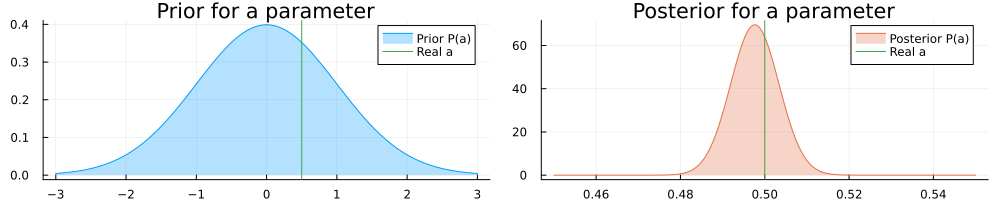

In [92]:
pra = plot(range(-3, 3, length = 1000), (x) -> pdf(NormalMeanVariance(0.0, 1.0), x), title="Prior for a parameter", fillalpha=0.3, fillrange = 0, label="Prior P(a)", c=1,)
pra = vline!(pra, [ reala_un ], label="Real a", c = 3)
psa = plot(range(0.45, 0.55, length = 1000), (x) -> pdf(results_unknown_noise.posteriors[:a], x), title="Posterior for a parameter", fillalpha=0.3, fillrange = 0, label="Posterior P(a)", c=2,)
psa = vline!(psa, [ reala_un ], label="Real a", c = 3)

plot(pra, psa, size = (1000, 200))

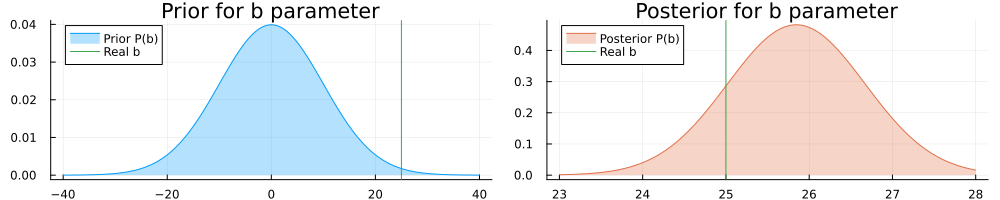

In [93]:
prb = plot(range(-40, 40, length = 1000), (x) -> pdf(NormalMeanVariance(0.0, 100.0), x), title="Prior for b parameter", fillalpha=0.3, fillrange = 0, label="Prior P(b)", c=1, legend = :topleft)
prb = vline!(prb, [ realb_un ], label="Real b", c = 3)
psb = plot(range(23, 28, length = 1000), (x) -> pdf(results_unknown_noise.posteriors[:b], x), title="Posterior for b parameter", fillalpha=0.3, fillrange = 0, label="Posterior P(b)", c=2, legend = :topleft)
psb = vline!(psb, [ realb_un ], label="Real b", c = 3)

plot(prb, psb, size = (1000, 200))

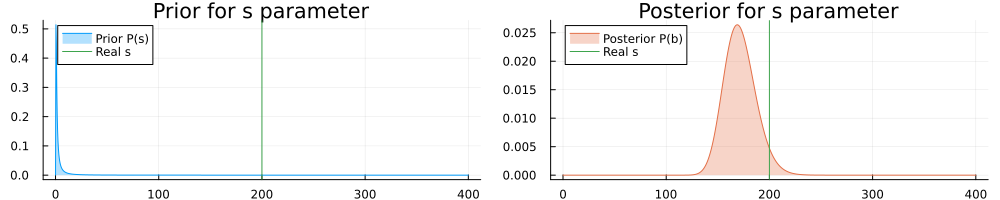

In [95]:
prb = plot(range(0.001, 400, length = 1000), (x) -> pdf(InverseGamma(1.0, 1.0), x), title="Prior for s parameter", fillalpha=0.3, fillrange = 0, label="Prior P(s)", c=1, legend = :topleft)
prb = vline!(prb, [ realv_un ], label="Real s", c = 3)
psb = plot(range(0.001, 400, length = 1000), (x) -> pdf(results_unknown_noise.posteriors[:s], x), title="Posterior for s parameter", fillalpha=0.3, fillrange = 0, label="Posterior P(b)", c=2, legend = :topleft)
psb = vline!(psb, [ realv_un ], label="Real s", c = 3)

plot(prb, psb, size = (1000, 200))

We can see that in the presence of more noise the inference result is more uncertain about the actual values for $a$ and $b$ parameters.

Lets sample $a$ and $b$ and plot many regression lines on the same plot:

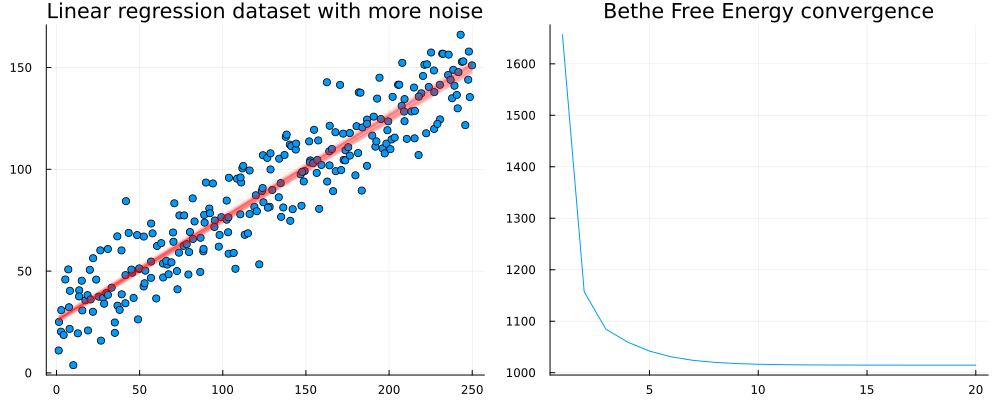

In [86]:
as = rand(results_unknown_noise.posteriors[:a], 100)
bs = rand(results_unknown_noise.posteriors[:b], 100)

p = scatter(xdata_un, ydata_un, title = "Linear regression dataset with more noise", legend=false)

for (a, b) in zip(as, bs)
    p = plot!(xdata_un, a .* xdata_un .+ b, alpha = 0.05, color = :red)
end

f = plot(results_unknown_noise.free_energy, title = "Bethe Free Energy convergence", label = nothing)

plot(p, f, size = (1000, 400))

From this plot we can see that many lines do fit the data well and there is no definite "best" answer to the regression coefficients. Most of these lines, however, resemble a similar angle and shift. Bethe Free Energy plot on the right hand side indicates that the inference procedure converged normally.